2022-04-21 15:55:48.901886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


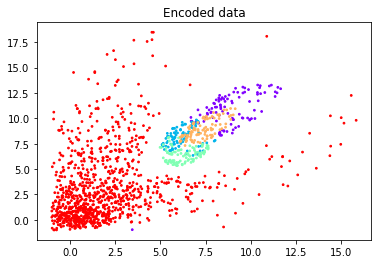

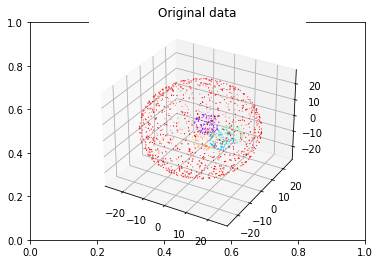

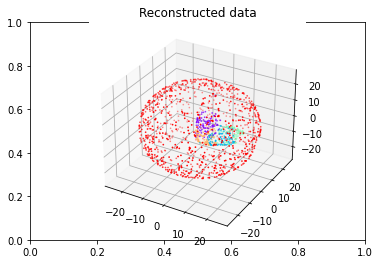

<Figure size 432x288 with 0 Axes>

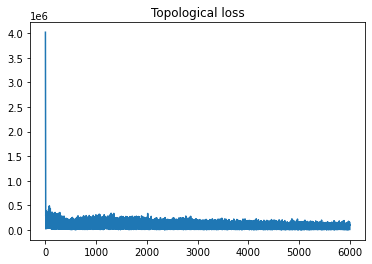

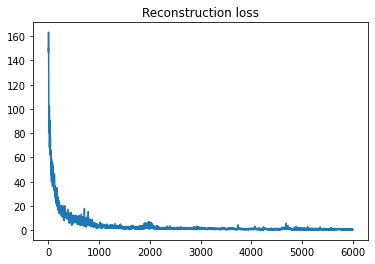

In [1]:
#%%

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Layer, Input
from tensorflow.keras import losses, Input
from tensorflow.keras import backend as K

from topolearn.util.spheres import  create_sphere_dataset

from topolearn.util import make_shells
from topolearn.simpcomplex import RipsComplex
from topolearn.loss import  TopologicalLoss

X, y = create_sphere_dataset(n_samples=100, d=2, n_spheres=5)

# Dimension of the original space
input_dim = X.shape[1]
# Dimension of the latent space (encoding space)
latent_dim = 2
#y, X = make_shells(4000, input_dim, noise=0.01)


# Autoencoder  model
encoder = Sequential(
    [
        Input(shape=(input_dim,)),
        Dense(256, activation="elu"),
        Dense(128, activation="elu"),
        Dense(64, activation="elu"),
        Dense(32, activation="elu"),
        Dense(latent_dim, activation="elu"),
    ]
)
decoder = Sequential(
    [
        Dense(64, activation="elu", input_shape=(latent_dim,)),
        Dense(128, activation="elu"),
        Dense(256, activation="elu"),
        Dense(input_dim, activation=None),
    ]
)
input_seq = encoder.input
output_seq = decoder(encoder.output)
model = Model(inputs=input_seq, outputs=output_seq)


# Training config
# Training config
epochs = 600
batch_size = 150
lambda_topo = 0.001
learning_rate = 1e-3
#
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_mse = keras.losses.MeanSquaredError()
topoloss = TopologicalLoss(
    filtration=RipsComplex(max_dim=1, max_radius = 1.5, verbose=0),
)

losses_mse = []
losses_topo = []

train_dataset = X
train_dataset = tf.data.Dataset.from_tensor_slices((X, X))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

for epoch in range(epochs):
    if  epoch % 10 == 0:
        # print(f"Start of epoch {epoch}")
        pass
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            middle = encoder(x_batch_train, training=True)
            preds = decoder(middle, training=True)

            loss_accuracy = loss_mse(y_batch_train, preds)
            loss_topo = topoloss(x_batch_train, middle)
            loss_value = loss_accuracy + lambda_topo * loss_topo

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        losses_mse.append(loss_accuracy)
        losses_topo.append(loss_topo)

        #if step % 200 == 0:
        #    print(
        #        f"Training loss (batch) at step {step}: mse: {loss_accuracy}, topo: {loss_topo}, total:{loss_value}"
        #    )


encoded = encoder(X)

Xaut = model.predict(X)

# Plot, plot, plot
plt.figure()
plt.title("Encoded data")
plt.scatter(encoded[:, 0], encoded[:, 1], c=y, cmap="rainbow", s=3)

plt.figure()
plt.title("Original data")
ax = plt.axes(projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap="rainbow", linewidth=0.5, s=0.5)

plt.figure()
plt.title("Reconstructed data")
ax = plt.axes(projection="3d")
ax.scatter(Xaut[:, 0], Xaut[:, 1], Xaut[:, 2], c=y, cmap="rainbow", s=0.5)
plt.figure()

plt.figure()
plt.title("Topological loss")
plt.plot(losses_topo)

plt.figure()
plt.title("Reconstruction loss")
plt.plot(losses_mse)




